In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import numpy as np
from cmdstanpy import CmdStanModel
from baynes import FitPlotter, get_compiler_kwargs, get_stan_file, standard_analysis, hdi
import pandas as pd

sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.6)
plt.rc("axes.spines", top=False, right=False)

import matplotlib as mpl
from matplotlib import cycler
colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"][4:8]#['#1b9e77','#e7298a','#d95f02','#7570b3','#66a61e','#e6ab02','#a6761d','#666666']
mpl.rcParams['axes.prop_cycle'] = cycler('color',colors)

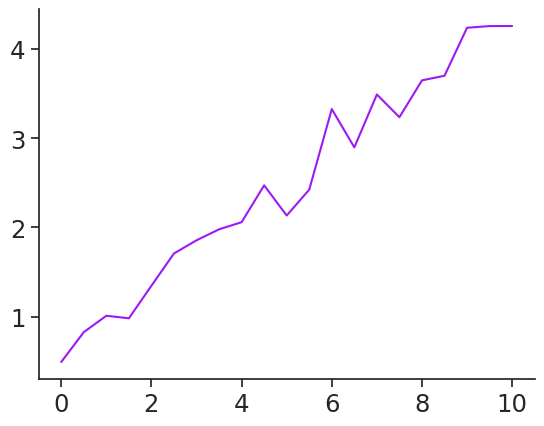

In [12]:
N = 21
x = np.linspace(0, 10, N)

alpha = 0.5
beta = 0.4
sigma = 0.5

y = alpha + beta * (x + np.random.normal(0, sigma, N))
plt.plot(x, y)

data = {'N': N, 'x': x, 'y': y, 'prior': 0}
fplot = FitPlotter(output_dir="/home/pietro/work/TESI/thesis/figures/ch2/linear/", output_format='.pdf', fig_ratio=1.2, fig_scale=6)

In [13]:
model = CmdStanModel(stan_file=get_stan_file('linear_simple.stan'),
                     **get_compiler_kwargs())
                     
model_noalpha = CmdStanModel(stan_file=get_stan_file('linear_no_intercept.stan'),
                            **get_compiler_kwargs())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/linear/linear_simple.stan
Found .stan file  /home/pietro/work/TESI/baynes/stan/models/linear/linear_no_intercept.stan


In [14]:
fit = model.sample(data)
fplot.add_fit(fit, 'with intercept')
fit_noalpha = model_noalpha.sample(data)
fplot.add_fit(fit_noalpha, 'no intercept')


10:02:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:02:49 - cmdstanpy - INFO - CmdStan done processing.
10:02:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:02:49 - cmdstanpy - INFO - CmdStan done processing.


Text(0, 0.5, 'y')

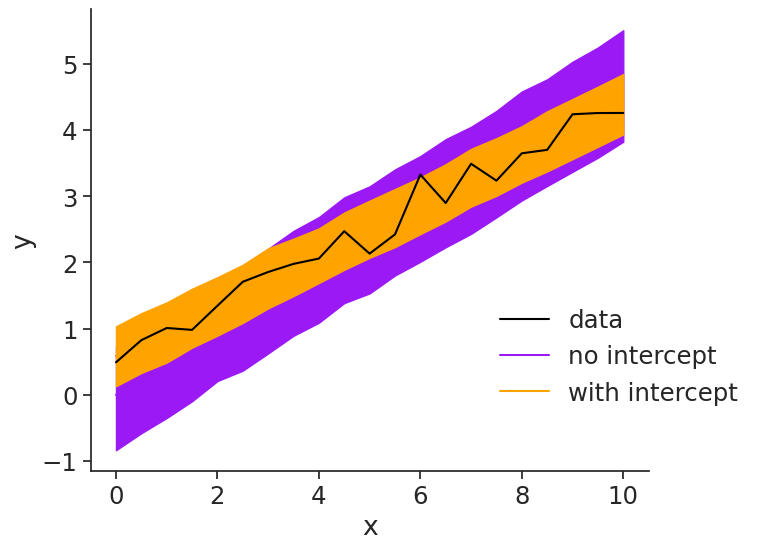

In [23]:
ax = fplot.new_figure('ppc_compare').subplots()
df_tot = pd.DataFrame()
for title, f in fplot.fits.items():
    df = f.draws_pd('y_rep').transpose()
    df['x']=x
    df['fit'] = title
    df_tot = pd.concat([df, df_tot])

#sns.set_palette(sns.cubehelix_palette(hue=1))
ax.plot(x, y, label='data', color='black')
ax = sns.lineplot(df_tot.melt(id_vars=['x', 'fit']), x='x', y='value', hue='fit', errorbar=hdi, ax=ax, err_kws={'alpha':1}, alpha=1, zorder=0)
plt.legend(bbox_to_anchor=(1.2, 0.4), facecolor='white', edgecolor='white')
ax.set_ylabel('y')
#fplot.save_figures()

In [25]:
np.ceil(3/2)

2.0

In [16]:
df = az.compare({'no intercept': fit_noalpha, 'with intercept':fit}, ic='waic')
print(df[['elpd_waic', 'se', 'p_waic']].to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & elpd_waic & se & p_waic \\
\midrule
with intercept & 2.43 & 3.03 & 2.20 \\
no intercept & -9.82 & 1.75 & 0.94 \\
\bottomrule
\end{tabular}



/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


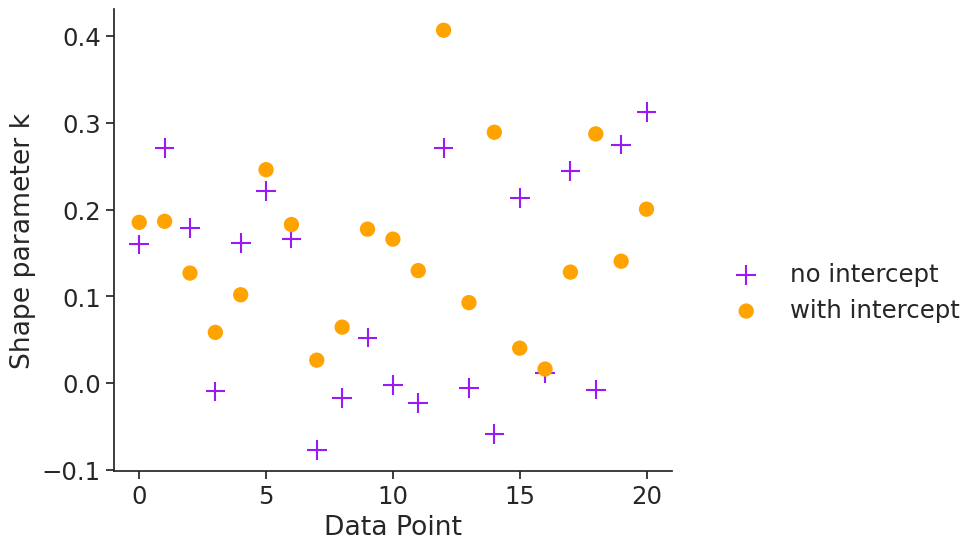

In [20]:
ax = fplot.new_figure('loo_khat').subplots()
loo = az.loo(fit_noalpha)
ax = az.plot_khat(loo, label = 'no intercept', ax=ax, markersize=200)
loo = az.loo(fit)
az.plot_khat(loo, label = 'with intercept', ax=ax, markersize=100, color=colors[1], marker='o')
plt.legend(bbox_to_anchor=(1.05, 0.5), facecolor='white', edgecolor='white')
fplot.save_figures()

In [18]:
df = az.compare({'no intercept': fit_noalpha, 'with intercept':fit})
print(df[['elpd_loo', 'se', 'p_loo']].to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & elpd_loo & se & p_loo \\
\midrule
with intercept & 2.37 & 3.06 & 2.26 \\
no intercept & -9.83 & 1.75 & 0.95 \\
\bottomrule
\end{tabular}



/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
